# Tutorial for batch processing in `expsolve`

We illustrate this with `expsolve.fourier`, which is imported as `ex`.

Batch processing is built-in in `expsolve` from ground up. This notebook demonstrates how to use it in practice.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

## Solving the Schrodinger equation, when initial conditions are in a batch

### Creating and visualizing a random batch of initial conditions

In [11]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)

V = x**4 - 10*x**2

def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u


### Computing matrix vector products - for brute force solution, for example

In [17]:
N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

D2 = ex.diffmatrix(2, n, xr).to(device)
H = -D2 + es.linalg.diag(V)

In [18]:
print(H.shape)
print(urtensor.shape)
print(es.linalg.matmul(H, urtensor).shape)

torch.Size([200, 200])
torch.Size([1000, 200])
torch.Size([1000, 200])


In [19]:
T = 1.

tim1 = time.time()
uTexpbatch = es.linalg.matmul(matrix_exp(-1j*T*H), urtensor)  
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    uTexploop = es.linalg.matmul(matrix_exp(-1j*T*H), ur)  
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 1000 took 0.017004013061523438s
Loop of size 1000 took 12.793421506881714s
Speed up factor 752.38 on cpu


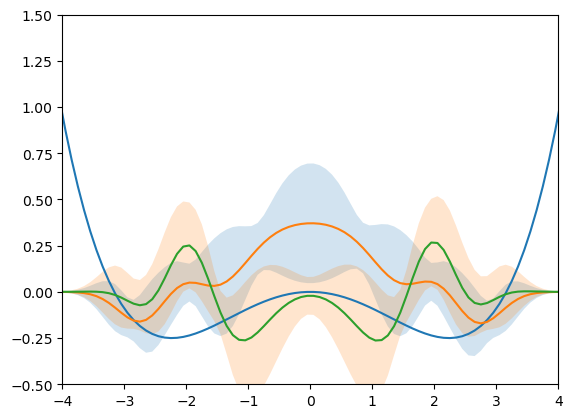

In [20]:
ex.plot(plt, x, V/100)
ex.plot(plt, x, real(uTexpbatch))
ex.plot(plt, x, imag(uTexpbatch))
plt.xlim([-4,4])
plt.ylim([-0.5,1.5])
plt.show()